# Project : Stock Price Prediction
The objective of this project is to accurately predict the  Adjusted closing value of a given stock across a given period of time.

The price of a stock can be modeled by a continuous stochastic process which is the sum between a predictable and an unpredictable part. Therefore I have used combination of Linear Regression {for modelling predictable part} and SVR { for modelling unpredictable part}.


### Importing Libraries

In [17]:
import pandas as pd
import datetime
from pandas_datareader import data, wb
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

### Function to get historical data of any stocks, from Yahoo Finance.



In [18]:
def get_historical_data(symbol,start_date,end_date):
    
    ''' Daily quotes from Yahoo Finance. Date format='datetime.date(yyyy-mm-dd)'
        symbol : stock symbol eg: GOOGL, FB , AAPL
        start_date, end _date =  period for which, data is required     
    '''
    symbol = symbol.upper()
    return data.DataReader(symbol, 'yahoo', start_date, end_date)

### Function to shift the dates by delta_time 
    This function is used to shift the prediction period by 5 years, to get train data

In [19]:
def train_dates(start_date,end_date,delta_time):
    
    start_date = datetime.date(int(start_date[0:4]), int(start_date[5:7]), int(start_date[8:10]))
    end_date = datetime.date(int(end_date[0:4]), int(end_date[5:7]), int(end_date[8:10]))
    #prediction_days = np.busday_count(start_date,end_date)
    train_start=(start_date +datetime.timedelta(-delta_time))
    train_end=(start_date +datetime.timedelta(-1))
    
    return train_start,train_end,start_date,end_date
    

### Function to remove weekends from a particular date range
    This function is required because Stock Prices are not available for weekends
    

In [20]:
def datetime_range(start_date, end_date,alpha):
    dates=[]
    span = end_date - start_date
    for i in range(span.days + 1):
        dates.append(start_date + datetime.timedelta(days=i))
    
    weekday=list(map(lambda x : x.weekday(),dates))
    dates=list(map(lambda x:(x-alpha).days,dates))
    
    date_range=[dates[i] for i in range(len(dates)) if weekday[i] not in [5,6] ]
    return date_range

## Linear Part

In [21]:
def get_prediction_linear(stock,start_date,end_date):
    
    '''
    stock : stock symbol eg: GOOGL, FB , AAPL
    start_date, end_date : period for which prediction is required
    Date format='yyyy-mm-dd'
    
    '''
    ## First Step is to shift both start_date and end_date by 5 years
    train_start,train_end,start_date,end_date = train_dates(start_date,end_date,5*365)   
    
    ## Retrieve Stock prices for shifted range
    df = get_historical_data(stock,train_start,train_end)    
    alpha=(df.index[0]).date()

    df=df.reset_index()
    
    ## Change the dates into integers, and get bot x_train and y_train
    
    df['Date']=df['Date'].apply(lambda x:(x.date()-alpha).days)
    X_train=df[['Date']]
    y_train=df[['Adj Close']]
    y_train=pd.DataFrame(data=np.array(y_train['Adj Close']),columns=y_train.columns,index=X_train['Date'])
    
    date_range=datetime_range(start_date, end_date,alpha)
    x_predict=pd.DataFrame(date_range,columns=['Date'])
    
    ## Linear Regression    
    from sklearn.linear_model import LinearRegression
    classifier = LinearRegression()
    classifier.fit(X_train, y_train)
    
    clf_prediction = classifier.predict(X_train)
    clf_prediction_train=pd.DataFrame(data=clf_prediction,columns=y_train.columns,index=X_train['Date'])
    
    clf_prediction = classifier.predict(x_predict)    
    clf_prediction_test=pd.DataFrame(data=clf_prediction,columns=y_train.columns,index=x_predict.Date) 
    
    ## Return the difference between predicted and actual value
    ### This difference will be modeled in further process
    stochastic_part=y_train-clf_prediction_train
    
    return stochastic_part,clf_prediction_train,clf_prediction_test,x_predict

## Stochastic Part

In [22]:
def stochastic_part(stock,start_date,end_date):
    
    ## Retrieve Stochastic part from linear Function
    stochastic_train,dummy1,dummy2,X_test=get_prediction_linear(stock,start_date,end_date)
    X_train=stochastic_train.reset_index()[['Date']]
    y_train=stochastic_train[['Adj Close']]
       
    from sklearn.svm import SVR
    svr_rbf = SVR(kernel='rbf', C=50, gamma=0.00001)
    
    svr_rbf.fit(X_train, y_train)
    stochastic_test=svr_rbf.predict(X_test)
    stochastic_train=svr_rbf.predict(X_train)
    
    stochastic_test=pd.DataFrame(stochastic_test,columns=y_train.columns,index=X_test.Date)
    stochastic_train=pd.DataFrame(stochastic_train,columns=y_train.columns,index=X_train.Date)
    
    return stochastic_train, stochastic_test

## Final Prediction

In [23]:
def stock_price_prediction(stock,start_date,end_date):
    
    dummy,linear_part_train,linear_part_test,X_test=get_prediction_linear(stock,start_date,end_date)
    stochastic_train,stochastic_test = stochastic_part(stock,start_date,end_date)
    
    stock_price_train = linear_part_train+stochastic_train
    stock_price_test = linear_part_test+stochastic_test
    
    train_start,train_end,start_date,end_date = train_dates(start_date,end_date,5*365)
   
    ## Retrieve Actual Stock Prices again for comparison
    y_train = get_historical_data(stock,train_start,train_end)[['Adj Close']]
    stock_price_train.index=y_train.index
    
    delta=stock_price_test.index-stock_price_test.index[0]
    new_index = [start_date + datetime.timedelta(x) for x in delta]
    stock_price_test.index=new_index
    actual_price = get_historical_data(stock,train_start,end_date)[['Adj Close']]   
    
    return stock_price_train,stock_price_test,actual_price

    
    

Enter stocks symbol	googl
Enter start date of prediction in yyyy-mm-dd format2020-01-01
Enter end date of prediction in yyyy-mm-dd format2020-12-31


C:\Users\priyanshu\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


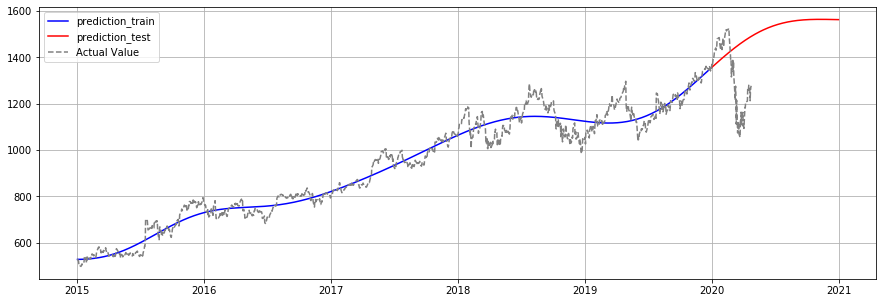

In [31]:
stock=input("Enter stocks symbol\t")
start_date=input("Enter start date of prediction in yyyy-mm-dd format")
end_date=input("Enter end date of prediction in yyyy-mm-dd format")
#############################################################################
stock_price_train,stock_price_test,actual=stock_price_prediction(stock,start_date,end_date)
plt.figure(figsize=[15,5])
plt.plot(stock_price_train,'b',label="prediction_train")
plt.plot(stock_price_test,'r',label="prediction_test")
plt.plot(actual,c='grey',linestyle='dashed',label="Actual Value")
plt.legend(loc='upper left')
plt.grid()
plt.show()
